![](https://pbs.twimg.com/media/FjR8QRLXkAIxis5?format=jpg&name=medium)

### <font color = #950CDF> Part 1: </font> <font color = #4854E8> Import the Libraries </font>

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import mmread
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
import powerlaw as po

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.3
Load (perhaps a sub-) set of stops from the data provided by ZTM Warszawa on the website www.ztm.waw.pl/ pliki-do-pobrania/dane-rozkladowe/. Draw graphs based on this set of vertices associated with the various types of mass transport.

In [4]:
import sys, time, json, random, os, re
from typing import Callable, Sequence, Iterator, Dict, Set
from math import cos, asin, sqrt, ceil
from collections import defaultdict


def download_ftp(path: str, output_path: str):
    if os.path.exists(output_path): return
    import ftplib
    ftp = ftplib.FTP(path)
    ftp.login("anonymous", "")
    files = ftp.nlst()

    pattern = re.compile(r"RA(\d+)\.7z")
    files = [f for f in files if re.match(pattern, f)]
    files.sort(key=lambda x: int(pattern.match(x).group(1)), reverse=True)

    with open(output_path, "wb") as output_file:
        ftp.retrbinary("RETR %s" % (files[0],), output_file.write)
    ftp.quit()


def decompress_data(path: str, output_path: str):
    if os.path.exists(output_path): return
    os.system("7z x %s -o%s" % (path, output_path))


class ZtmFormatIterator(object):
    def __init__(self, iterator: Iterator, tag):
        self.__iter = iterator
        self.__tag = tag
        self.__start = "*" + tag
        self.__end = "#" + tag

    @classmethod
    def iterate(cls, iter: Iterator, tag: str):
        return ZtmFormatIterator(iter, tag)

    def run(self, processor: Callable):
        lines = []
        append_mode = False
        while True:
            line = self.__iter.__next__()
            line = line.strip()
            if not append_mode and self.isstart(line):
                append_mode = True
                continue
            elif append_mode and self.isend(line):
                processor(lines)
                break

            if append_mode:
                lines.append(line)

    def isstart(self, line: str):
        return line.startswith(self.__start)

    def isend(self, line: str):
        return line.startswith(self.__end)


class ZtmFormatReader(object):
    def __init__(self, data_dir, metro_path):
        self.data_dir = data_dir
        self.data_file = os.path.join(self.data_dir, os.listdir(data_dir)[0])
        self.metro_path = metro_path
        self.points = {}
        self.routes_num = 0
        self.route_types = set()

    def read(self):
        start = time.time()
        with open(self.data_file, encoding="windows-1250") as input_file:
            iterator = input_file.__iter__()
            self.iterate(iterator, "ZP").run(self.read_point_groups)
            print("Parsed %d data points %.2fs" % (len(self.points), time.time() - start))

            start = time.time()
            try:
                while True:
                    self.iterate(iterator, "WK").run(self.read_routes)
            except StopIteration:
                pass

        self.read_metro()
        print("Parsed %d edges %.2fs" % (self.routes_num, time.time() - start))
        print("Known route types: " + self.route_types.__str__())
        return self.points

    def read_metro(self):
        with open(self.metro_path, "r", encoding="utf-8") as metro_file:
            data = json.load(metro_file)
            for metro_line in data:
                self.read_metro_line(metro_line)

    def read_metro_line(self, metro_line: Dict):
        points = metro_line["points"]
        times = metro_line["times"]
        trains = metro_line["trains"]
        for point in points:
            point["routes"] = []
            self.points[point["code"]] = point

        self.generate_metro_routes(points, times, trains["week"], "DP")
        self.generate_metro_routes(points, times, trains["saturday"], "SB")
        self.generate_metro_routes(points, times, trains["sunday"], "DS")

    def generate_metro_routes(self, points: Sequence[Dict], times: Sequence[int], trains: Sequence[Dict],
                              route_type: str):
        for time_window in trains:
            time_window["from"] = self.as_time(time_window["from"], sep=":")
            time_window["to"] = self.as_time(time_window["to"], sep=":")

        current_time = 0
        time_window_idx = 0
        current_time_window = trains[0]
        while current_time < 1440:
            if current_time >= current_time_window["to"]:
                time_window_idx += 1
                if time_window_idx >= len(trains):
                    break
                current_time_window = trains[time_window_idx]
            if current_time < current_time_window["from"]:
                current_time = current_time_window["from"]

            if "rate" in current_time_window:
                current_time += random.choice(current_time_window["rate"])
                self.generate_metro_route(points, times, route_type, current_time)
            elif "start" in current_time_window:
                for element in current_time_window["start"]:
                    start = current_time_window["from"] + element
                    self.generate_metro_route(points, times, route_type, start)
                current_time = current_time_window["to"]
            else:
                raise Exception("Invalid time window")

    def generate_metro_route(self, points: Sequence[Dict], times: Sequence[int], route_type: str, start: int):
        current_time = start
        for idx, duration in enumerate(times):
            if current_time >= 1440: return
            route = {"to": points[idx + 1]["code"], "start": current_time, "time": duration, "type": route_type}
            points[idx]["routes"].append(route)
            self.routes_num += 1
            current_time += duration

    def iterate(self, iter: Iterator, tag: str) -> ZtmFormatIterator:
        return ZtmFormatIterator.iterate(iter, tag)

    def read_point_groups(self, lines: Sequence[str]):
        try:
            iter = lines.__iter__()
            while True:
                self.iterate(iter, "PR").run(self.read_points)
        except StopIteration as e:
            return

    def read_points(self, lines: Sequence[str]):
        for line in lines:
            if len(line) > 6 and re.match(r"\d{6}\s", line):
                arr = re.split(r"\s\s+", line)
                self.read_point(arr)

    def read_point(self, arr: Sequence[str]):
        lat = re.findall(r"\d+\.\d+", arr[4])
        lon = re.findall(r"\d+\.\d+", arr[5])
        if len(lon) == 0 or len(lat) == 0:
            # there are some cases of missing geo locations
            lon = None
            lat = None
        else:
            lon = float(lon[0])
            lat = float(lat[0])

        code = arr[0]
        name = arr[2].strip(",")
        point = {"name": name, "code": code, "lon": lon, "lat": lat, "routes": []}
        self.points[code] = point

    def read_routes(self, lines: Sequence[str]):
        records = [line.split() for line in lines]
        current_route = records[0][0]
        previous_point = None
        previous_time = None
        for record in records:
            route = record[0]
            point = record[1]
            route_type = record[2]
            time = self.as_time(record[3])
            if route == current_route and previous_point is not None:
                self.add_route(previous_point, point, route_type, time, time - previous_time)
            elif route != current_route:
                current_route = route
            previous_point = point
            previous_time = time

    def add_route(self, point_from: str, point_to: str, route_type: str, time_start: int, duration: int):
        self.route_types.add(route_type)
        res = {"to": point_to, "start": time_start, "time": duration, "type": route_type}
        point = self.points.get(point_from)
        routes = point.get("routes")
        routes.append(res)
        self.routes_num += 1

    def as_time(self, value: str, sep: str = ".") -> int:
        split = [int(val) for val in value.split(sep)]
        res = split[0] * 60 + split[1]
        return res % 1440


class ZtmPostProcessor(object):
    def __init__(self, points: Dict):
        self.points = points

    def fill_missing_values(self):
        for point in self.points.values():
            if point["lon"] is None:
                self.__fill_missing_values(point)

    def __fill_missing_values(self, point):
        routes = point["routes"]
        lon, lat, size = 0, 0, 0
        destinations = set()
        for route in routes:
            destination = self.points[route["to"]]
            if destination["lon"] is None or destination["code"] in destinations:
                continue
            lon += destination["lon"]
            lat += destination["lat"]
            size += 1
            destinations.add(destination["code"])

        if size == 0:
            point["lon"] = 21.017532
            point["lat"] = 52.237049
        else:
            lon /= size
            lat /= size
            point["lon"] = lon
            point["lat"] = lat

    def add_walk_routes(self, max_distance: float, max_points: int):
        for point in self.points.values():
            self.__add_walk_routes(point, max_distance, max_points)

    def __add_walk_routes(self, point: Dict, max_distance: float, max_points: int):
        if point["lon"] is None: return
        for other in self.points.values():
            if other["lon"] is None:
                other["dist"] = sys.maxsize
            else:
                other["dist"] = self.dist(point["lon"], point["lat"], other["lon"], other["lat"])
        self.points[point["code"]]["dist"] = sys.maxsize

        res = sorted(self.points.values(), key=lambda row: row["dist"])
        idx = 0
        routes = point["routes"]
        while idx < max_points:
            row = res[idx]
            if idx > 0 and row["dist"] > max_distance:
                break
            routes.append({"to": row["code"], "time": ceil(12 * row["dist"]), "type": "WALK"})
            idx += 1

    def dist(self, lat1, lon1, lat2, lon2):
        p = 0.017453292519943295  # pi / 180
        a = 0.5 - cos((lat2 - lat1) * p) / 2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
        return 12742 * asin(sqrt(a))  # 2 * R * asin()


class ZtmJsonWriter:
    def __init__(self, points: Dict, output_dir: str):
        self.points = points
        self.output_dir = output_dir

    def write(self):
        self.write_points()
        #self.write_routes()

    def write_routes(self):
        types = {
            "week": {"D1", "D2", "D3", "D4", "D5", "N1", "N2", "N3", "N4", "N7", "DP", "NO", "NS"},
            "sat": {"D6", "N5", "SB", "NO", "NP", "NS"},
            "sun": {"D7", "N6", "DS", "TS", "NO", "NP", "NS"}
        }
        for key, val in types.items():
            idx = 0
            for start in range(0, 1440, 60):
                end = (start + 120) % 1440
                filename = "routes_%s_%d.json" % (key, idx)
                self.write_routes_file(start, end, val, filename)
                idx += 1

    def write_routes_file(self, start: int, end: int, types: Set[str], filename: str):
        res = dict()
        for point in self.points.values():
            routes = self.filter_routes(point["routes"], start, end, types)
            if len(routes) == 0:
                continue
            res[point["code"]] = routes
        self.__write_json(res, filename)

    def filter_routes(self, routes: Sequence[Dict], start: int, end: int, types: Set[str]) -> Dict:
        res = defaultdict(list)
        check_time = lambda rs: rs < start or rs > end
        if end < start:
            check_time = lambda rs: not (rs > start or rs < end)

        for route in routes:
            route_type = route["type"]
            route_start = route.get("start", None)
            duration = route["time"]
            if route_type not in types or check_time(route_start):
                continue
            res[route["to"]].append([route_start, duration])
        return {key: sorted(val, key=lambda item: item[0]) for key, val in res.items()}

    def write_points(self):
        res = dict()
        for point in self.points.values():
            #routes = {route["to"]: route["time"] for route in point["routes"] if route["type"] == "WALK"}
            routes = {route["to"]:route["type"] for route in point["routes"] if route["type"] != "WALK"}
            res[point["code"]] = {"lon": point["lon"], "lat": point["lat"], "routes": routes}
        #self.__write_json(res, "points.json")
        self.__write_json(res, "points2.json")

    def __write_json(self, obj, file_name):
        output_path = os.path.join(self.output_dir, file_name)
        with open(output_path, "w", encoding="utf-8") as output_file:
            json.dump(obj, output_file, separators=(",", ":"))
            print("%s" % (file_name,))

In [2]:
download_ftp("rozklady.ztm.waw.pl", "downloaded.7z")
decompress_data("downloaded.7z", "downloaded")

In [168]:
reader = ZtmFormatReader("downloaded", "data/metro.json")
points = reader.read()

Parsed 6829 data points 0.08s
Parsed 1658463 edges 7.48s
Known route types: {'SB', 'DS', 'D6', 'NS', 'N7', 'DP', 'NO', 'NP', 'D7'}


In [204]:
processor = ZtmPostProcessor(points)
processor.add_walk_routes(max_distance=1, max_points=100)
processor.fill_missing_values()

writer = ZtmJsonWriter(points, "./datasets")
writer.write()

points2.json


In [5]:
f = open("./datasets/points2.json")
data = json.load(f)
f.close()

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.5
Translate GPS coordinates to conﬁguration of the vertices and draw graph in proper, geographic, conﬁguration.

### All

In [6]:
All=nx.Graph()

In [7]:
for station in data:
    All.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        All.add_edge(station,connection)

In [18]:
import mplleaflet

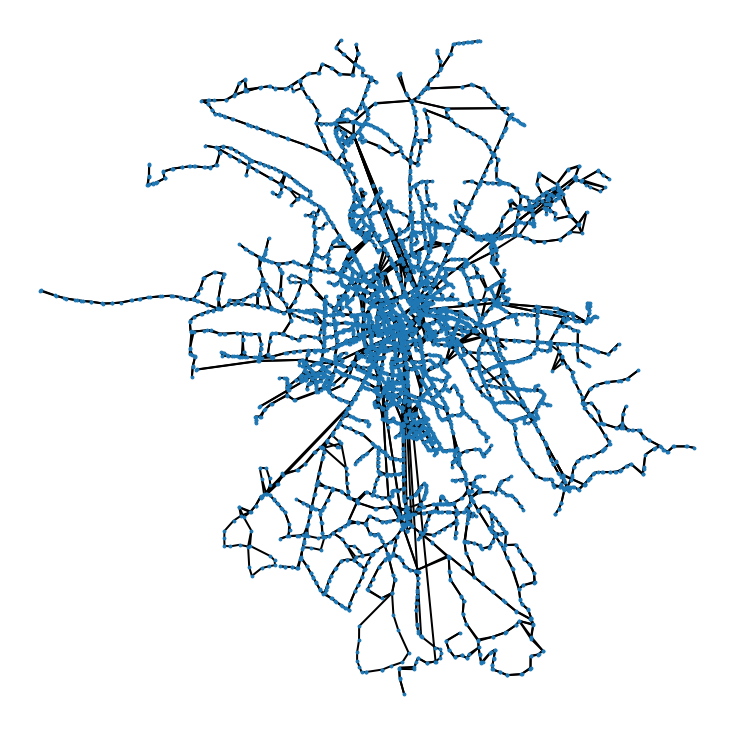

In [26]:
pos={g:np.array([All.nodes()[g]["lon"],All.nodes()[g]["lat"]]) for g in All.nodes()}

plt.figure(figsize=(10,10))
nx.draw(All,pos=pos,node_size=8,width=2)

In [27]:
import matplotlib.pyplot as plt
import mplleaflet
import networkx as nx

pos={g:np.array([All.nodes()[g]["lon"],All.nodes()[g]["lat"]]) for g in All.nodes()}

fig, ax = plt.subplots()

nx.draw_networkx_nodes(All,pos=pos,node_size=20,node_color='red',alpha=.5)
nx.draw_networkx_edges(All,pos=pos, alpha=.4)

mplleaflet.show(fig=fig,path="warsaw.html")

In [286]:
all_codes=set()

for station in data:
    for connection in data[station]['routes']:
        all_codes.add(data[station]['routes'][connection])

all_codes

{'D7', 'DP', 'DS', 'NO', 'NP', 'NS', 'SB'}

### D7

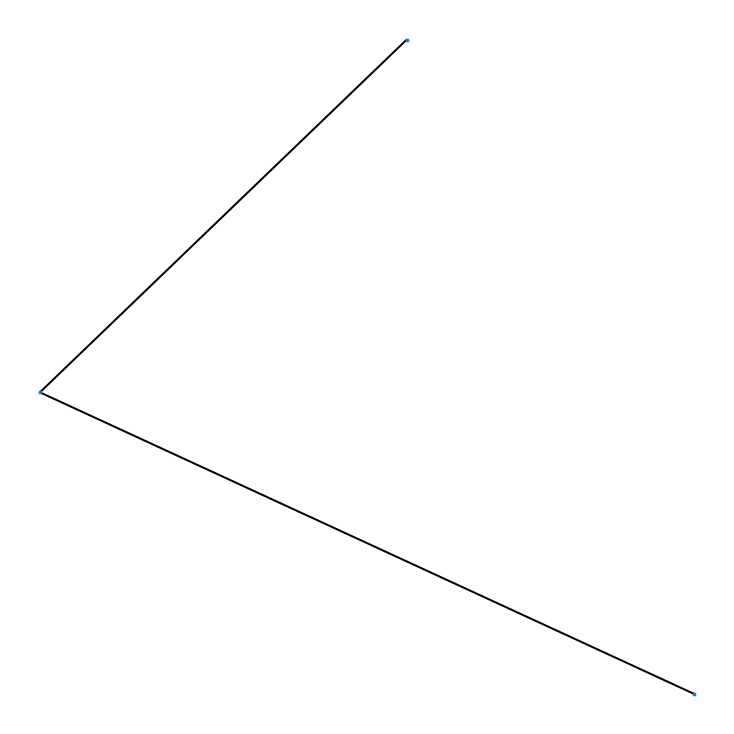

In [289]:
D7=nx.Graph()
for station in data:
    #print(station)
    D7.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "D7" in data[station]['routes'][connection]:
            D7.add_edge(station,connection)

D7.remove_nodes_from(list(nx.isolates(D7)))
pos={g:np.array([D7.nodes()[g]["lon"],D7.nodes()[g]["lat"]]) for g in D7.nodes()}
plt.figure(figsize=(10,10))
nx.draw(D7,pos=pos,node_size=8,width=2)

### DP

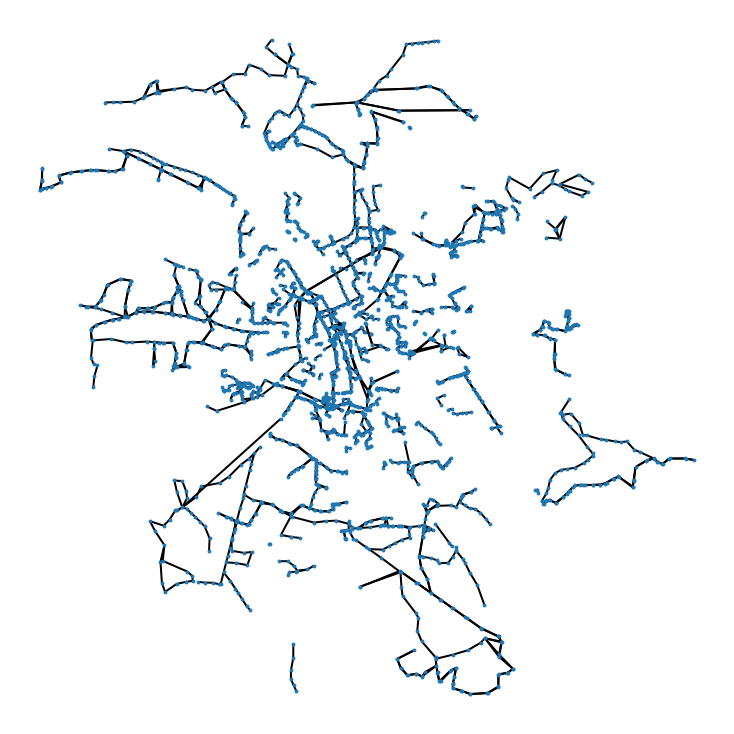

In [290]:
DP=nx.Graph()
for station in data:
    #print(station)
    DP.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "DP" in data[station]['routes'][connection]:
            DP.add_edge(station,connection)

DP.remove_nodes_from(list(nx.isolates(DP)))
pos={g:np.array([DP.nodes()[g]["lon"],DP.nodes()[g]["lat"]]) for g in DP.nodes()}
plt.figure(figsize=(10,10))
nx.draw(DP,pos=pos,node_size=8,width=2)

### DS

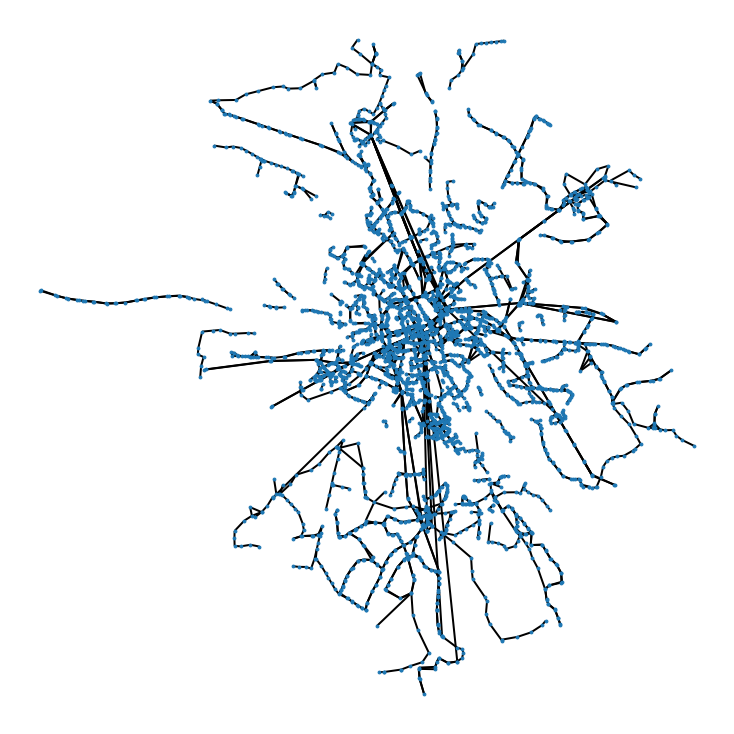

In [280]:
DS=nx.Graph()
for station in data:
    #print(station)
    DS.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "DS" in data[station]['routes'][connection]:
            DS.add_edge(station,connection)

DS.remove_nodes_from(list(nx.isolates(DS)))
pos={g:np.array([DS.nodes()[g]["lon"],DS.nodes()[g]["lat"]]) for g in DS.nodes()}
plt.figure(figsize=(10,10))
nx.draw(DS,pos=pos,node_size=8,width=2)

### NO

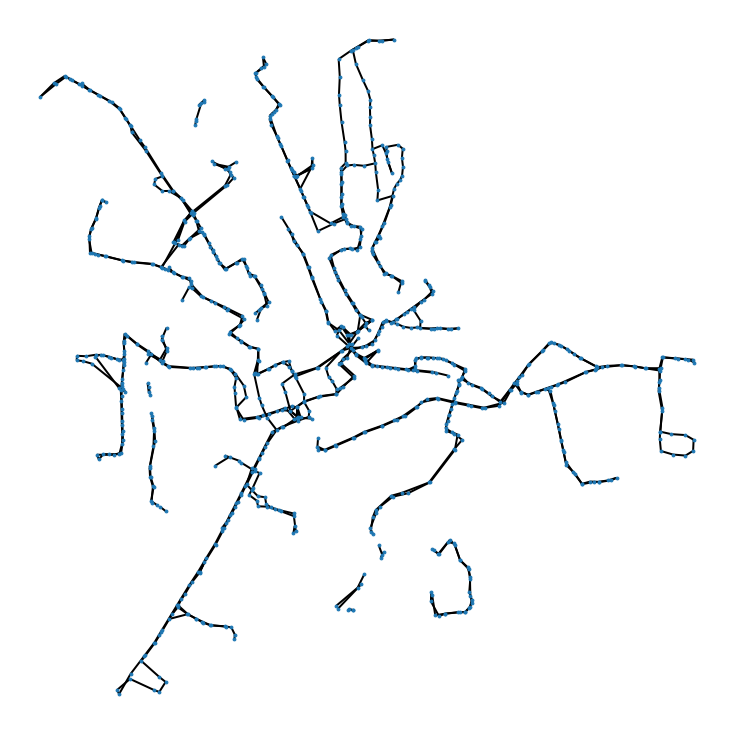

In [291]:
NO=nx.Graph()
for station in data:
    #print(station)
    NO.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "NO" in data[station]['routes'][connection]:
            NO.add_edge(station,connection)

NO.remove_nodes_from(list(nx.isolates(NO)))
pos={g:np.array([NO.nodes()[g]["lon"],NO.nodes()[g]["lat"]]) for g in NO.nodes()}
plt.figure(figsize=(10,10))
nx.draw(NO,pos=pos,node_size=8,width=2)

### NP

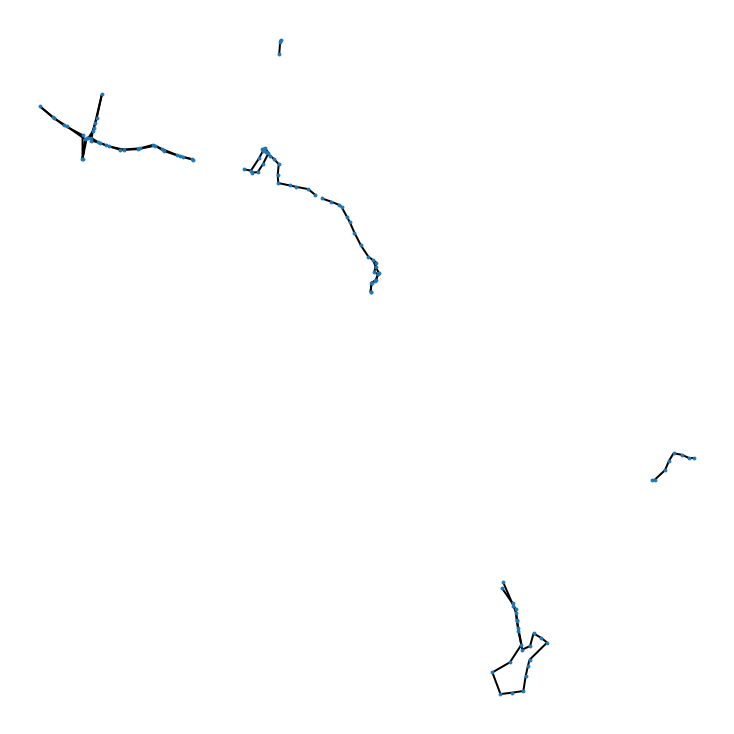

In [292]:
NP=nx.Graph()
for station in data:
    #print(station)
    NP.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "NP" in data[station]['routes'][connection]:
            NP.add_edge(station,connection)

NP.remove_nodes_from(list(nx.isolates(NP)))
pos={g:np.array([NP.nodes()[g]["lon"],NP.nodes()[g]["lat"]]) for g in NP.nodes()}
plt.figure(figsize=(10,10))
nx.draw(NP,pos=pos,node_size=8,width=2)

### NS

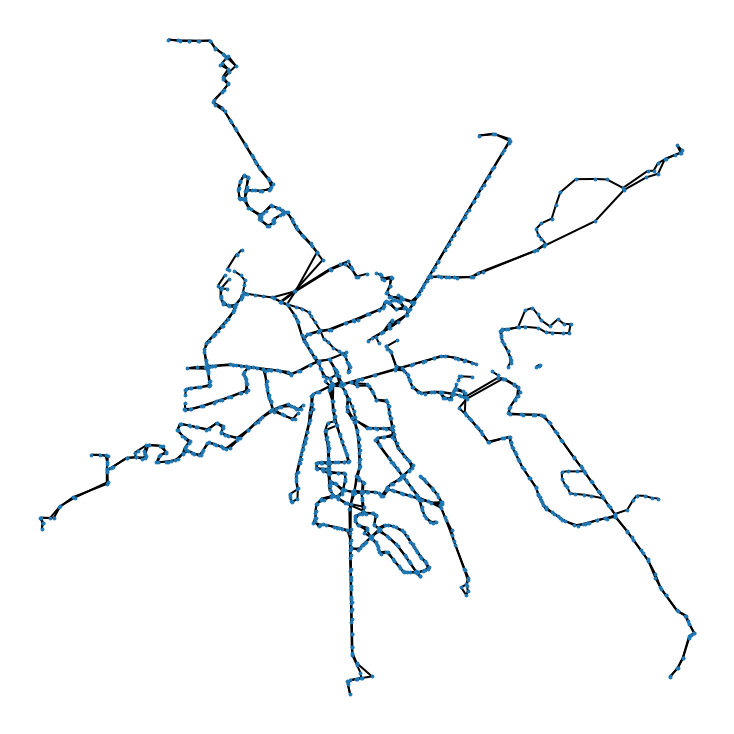

In [293]:
NS=nx.Graph()
for station in data:
    #print(station)
    NS.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "NS" in data[station]['routes'][connection]:
            NS.add_edge(station,connection)

NS.remove_nodes_from(list(nx.isolates(NS)))
pos={g:np.array([NS.nodes()[g]["lon"],NS.nodes()[g]["lat"]]) for g in NS.nodes()}
plt.figure(figsize=(10,10))
nx.draw(NS,pos=pos,node_size=8,width=2)

### SB

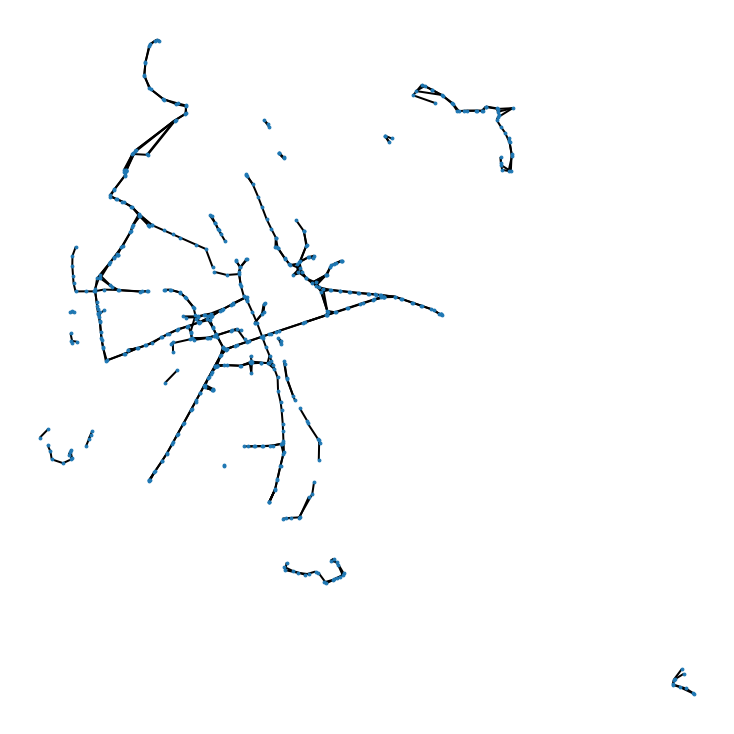

In [294]:
SB=nx.Graph()
for station in data:
    #print(station)
    SB.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    for connection in data[station]['routes']:
        if "SB" in data[station]['routes'][connection]:
            SB.add_edge(station,connection)

SB.remove_nodes_from(list(nx.isolates(SB)))
pos={g:np.array([SB.nodes()[g]["lon"],SB.nodes()[g]["lat"]]) for g in SB.nodes()}
plt.figure(figsize=(10,10))
nx.draw(SB,pos=pos,node_size=8,width=2)

### Metro

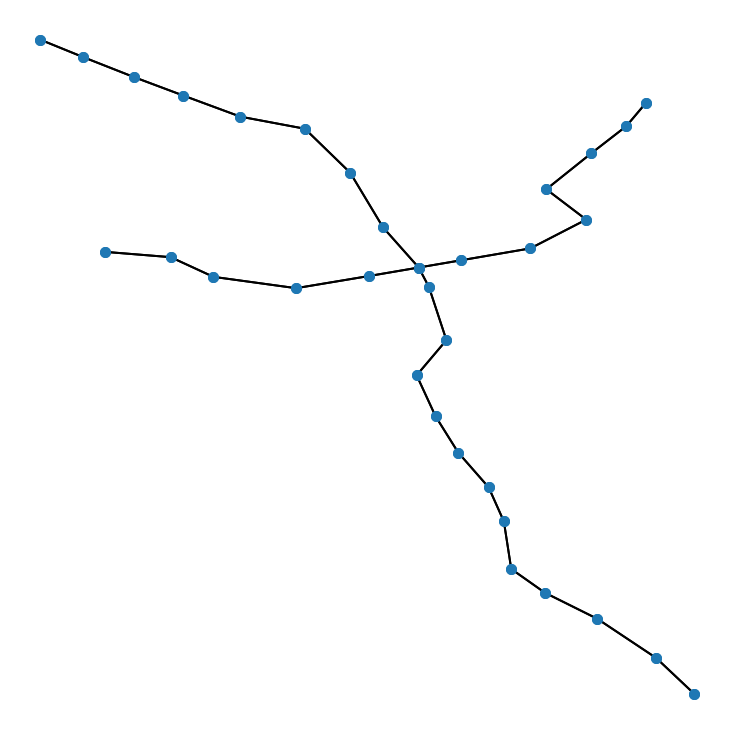

In [295]:
Metro=nx.Graph()

for station in data:
    if "M" in station:
        #print(station)
        Metro.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
        for connection in data[station]['routes']:
            if "M" in connection:
                Metro.add_edge(station,connection)

pos={g:np.array([G.nodes()[g]["lon"],G.nodes()[g]["lat"]]) for g in Metro.nodes()}

plt.figure(figsize=(10,10))
nx.draw(Metro,pos=pos,node_size=100,width=2)

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.4
Calculate the basic characteristics of each layer, and the whole network.

In [296]:
def get_alpha(G):
    deg=nx.degree_histogram(G)
    d=np.concatenate([np.array([i]*deg[i],dtype="int") for i in range(len(deg))])
    fit=po.Fit(d)
    return fit.alphas[0]

In [297]:
table=pd.DataFrame(columns=["name","N","E","<k>","alpha","l","r","C"])

In [298]:
name='All'
G = All
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/olaf/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [299]:
name='Metro'
G = Metro
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [300]:
name='D7'
G = D7
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [301]:
name='DP'
G = DP
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [302]:
name='DS'
G = DS
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [303]:
name='NO'
G = NO
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [304]:
name='NP'
G = NP
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit
/home/olaf/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


In [305]:
name='NS'
G = NS
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [306]:
name='SB'
G = SB
table=table.append({"name":name,"N":len(G.nodes()),"E":len(G.edges()),"<k>":2*len(G.edges())/len(G.nodes()),"alpha":get_alpha(G),"l":len(nx.degree_histogram(G)),"r":nx.degree_pearson_correlation_coefficient(G),"C":np.array(list(nx.clustering(G).values())).mean()},ignore_index=True)

Calculating best minimal value for power law fit


In [312]:
table

,name,N,E,<k>,alpha,l,r,C
0,All,6897,9055,2.625779,2.109368,17,0.221777,0.023066
1,Metro,68,64,1.882353,2.635054,3,-0.066667,0.000000
2,D7,3,2,1.333333,5.328085,3,-1.000000,0.000000
3,DP,2502,2357,1.884093,2.753151,8,0.008595,0.003816
4,DS,6897,3754,1.088589,2.640233,8,0.040026,0.004782
5,NO,929,949,2.043057,2.456472,8,0.152715,0.000897
6,NP,111,105,1.891892,2.648032,5,-0.000502,0.000000
7,NS,1270,1316,2.072441,2.424103,11,0.113144,0.000656
8,SB,561,574,2.046346,2.547045,6,0.163590,0.000000


![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.1
Prepare a code which draw for given network plot of the relation C(k)

In [313]:
def draw_C_k(G):
    deg=dict(G.degree())

    C=nx.clustering(G)

    d=[deg[i] for i in deg.keys()] 

    C=[C[i] for i in deg.keys()]

    d=np.array(d)

    C=np.array(C)

    sns.scatterplot(x=d,y=C)
    sns.lineplot(x=d[d>0],y=1/d[d>0],color="red")

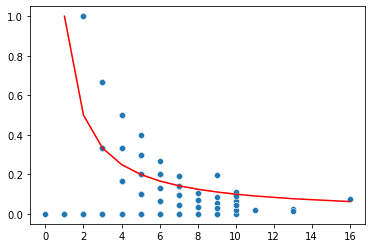

In [316]:
draw_C_k(All)

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.6
Taking into account the time table data, obtain the temporal network from the graphs from the previous task.

In [320]:
f = open("./datasets/points2.json")
data = json.load(f)
f.close()

In [321]:
f = open("./datasets/ztm/routes_sat_0.json")
data2 = json.load(f)
f.close()

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## <font color = #41EA46> Excercise P8.7 
Trafﬁc ﬂows throughout the day.

In [349]:
Temp=nx.Graph()

for station in data:
    Temp.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
    if station in data2.keys():
        for connection in data2[station]:
                for x in data2[station][connection]:
                    if x[1]>0:
                        Temp.add_edge(station,connection,time=x[0])

pos={g:np.array([Temp.nodes()[g]["lon"],Temp.nodes()[g]["lat"]]) for g in Temp.nodes()}

plt.figure(figsize=(10,10))
nx.draw(Temp,pos=pos,node_size=8,width=2)

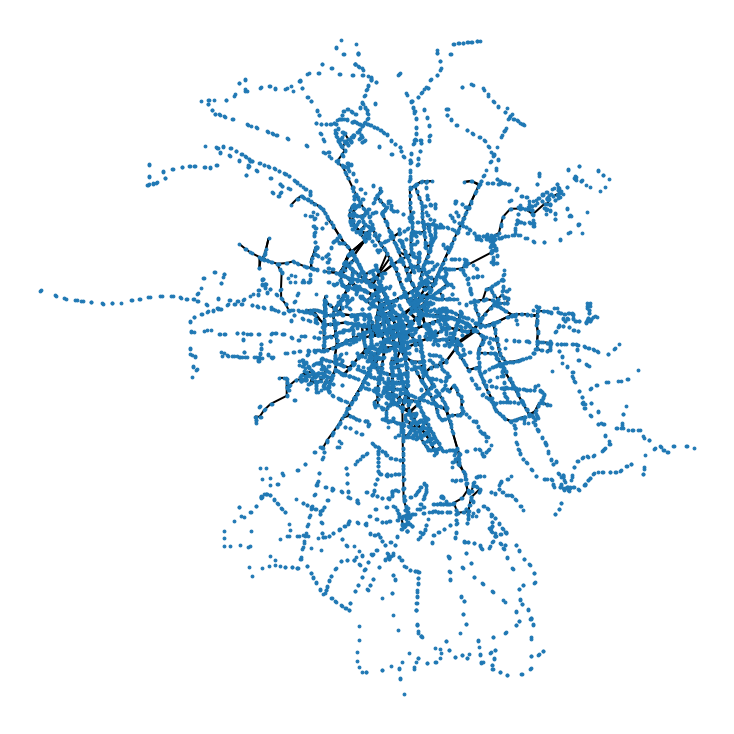

In [353]:
from matplotlib import pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(10,10))
camera = Camera(fig)
for i in range(24):
    f = open("./datasets/ztm/routes_sat_{}.json".format(i))
    data2 = json.load(f)
    f.close()
    Temp=nx.Graph()

    for station in data:
        Temp.add_node(station,lon=data[station]['lon'], lat=data[station]['lat'])
        if station in data2.keys():
            for connection in data2[station]:
                    for x in data2[station][connection]:
                        if x[1]>0:
                            Temp.add_edge(station,connection,time=x[0])

    pos={g:np.array([Temp.nodes()[g]["lon"],Temp.nodes()[g]["lat"]]) for g in Temp.nodes()}

    nx.draw(Temp,pos=pos,node_size=8,width=2)
    camera.snap()
animation = camera.animate()
animation.save('warsaw.gif', writer = 'imagemagick')

![SNAR](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)